In [1]:
from pathlib import Path
import cucim
import numpy as np
from matplotlib import pylab as plt
import pyclesperanto_prototype as cle

from multipagetiff import MultiPageTIFF
from integershearingcorrect import IntegerShearingCorrect
from autocropper import AutoCropper

In [2]:
fpath = Path("/mnt/ssd1/substacks_13/x_127.20000_y_119.90000_z_000.00000__cam_l_8bit.tif")
mptiff = MultiPageTIFF(img_path=fpath, n_threads=10)

In [3]:
mptiff.shape

(8234, 2048, 2048)

In [4]:
imgstack = mptiff[4000:4100]

Reading 100 slices with 10 processes with chunk size 10


100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 886745.03it/s]

Time: 21.37493872642517


In [8]:
imgstack.shape

(100, 2048, 2048)

In [9]:
crop = AutoCropper(imgstack)

In [10]:
cropped_vol = crop.crop()

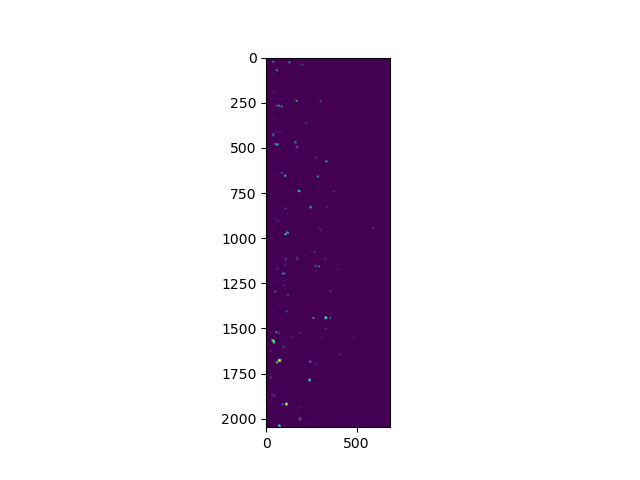

In [14]:
%matplotlib ipympl
plt.imshow(cropped_vol[50])

In [15]:
isc = IntegerShearingCorrect(delta=-7)
shear_corrected_vol, mask = isc.forward_correct(cropped_vol)
plt.imshow(shear_corrected_vol[50])

# Voronoi-Otsu Labeling with pyclesperanto

In [16]:
cle.select_device("NVIDIA GeForce RTX 3090")
input_gpu = cle.push(shear_corrected_vol)

cl.OCLArray([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
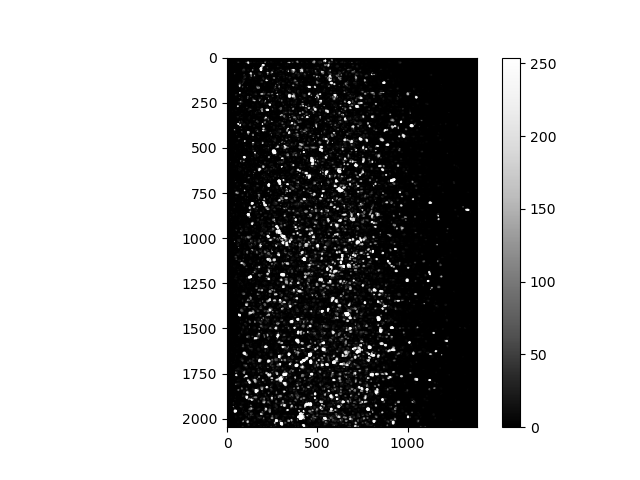
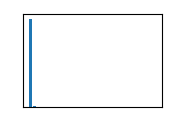

In [17]:
input_gpu

In [18]:
sigma_detection=5
sigma_outline = 1
segmented= cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_detection, outline_sigma=sigma_outline)

size: 100


In [19]:
asd = np.array(segmented)

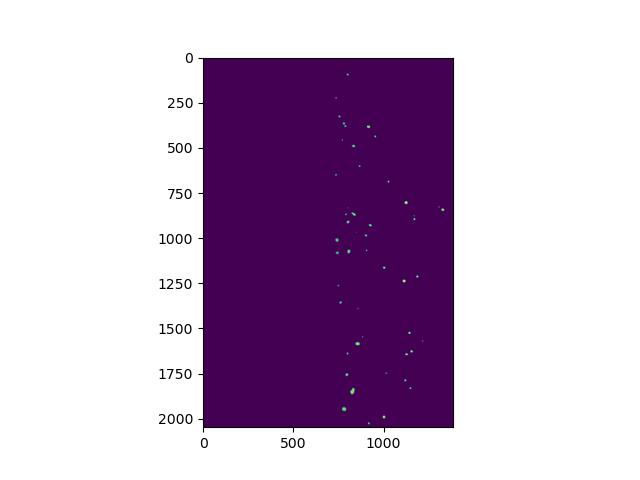

In [20]:
plt.imshow(asd[0])

In [22]:
import zetastitcher as zs

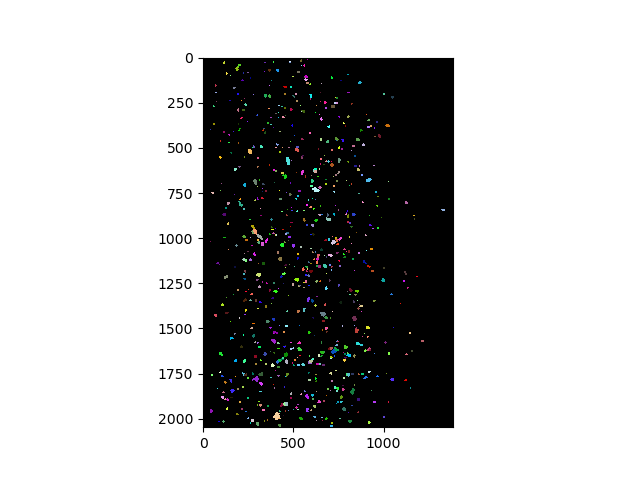

In [26]:
cle.imshow(cle.maximum_z_projection(asd),labels=True)

In [35]:
import pandas as pd
pd.DataFrame(cle.statistics_of_labelled_pixels(input_gpu, segmented))


,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
0,1,1,38.0,399.0,99.0,43.0,404.0,99.0,6.0,6.0,...,99.000008,61.692707,2.056424,61.691666,2.056389,10.356748,3.004624,3.013263,1.461092,1.465318
1,2,2,40.0,1018.0,98.0,43.0,1022.0,99.0,4.0,5.0,...,98.772728,33.034332,1.501561,33.067791,1.503081,13.366495,2.458307,2.534809,1.637168,1.686408
2,3,3,36.0,1951.0,96.0,55.0,1968.0,99.0,20.0,18.0,...,97.830536,5862.721680,6.171287,5873.910156,6.183064,81.028046,11.196964,11.192780,1.814365,1.810232
3,4,4,46.0,1755.0,97.0,57.0,1766.0,99.0,12.0,12.0,...,98.418808,891.000000,3.807693,892.746033,3.815154,57.598820,6.705706,6.622209,1.761094,1.735764
4,5,5,47.0,745.0,98.0,60.0,756.0,99.0,14.0,12.0,...,98.597221,887.642151,4.109455,889.977112,4.120265,26.206181,7.319434,7.520917,1.781121,1.825348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,788,788,1181.0,1210.0,0.0,1191.0,1219.0,0.0,11.0,10.0,...,0.000000,338.695984,3.641892,338.756866,3.642547,17.477072,5.631105,5.686919,1.546203,1.561248
788,789,789,1187.0,1646.0,2.0,1190.0,1650.0,3.0,4.0,5.0,...,2.111111,26.396511,1.466473,26.504375,1.472465,27.146212,2.132188,2.076387,1.453957,1.410143
789,790,790,1208.0,1565.0,0.0,1223.0,1577.0,5.0,16.0,13.0,...,2.409807,2672.039551,4.679579,2672.947021,4.681168,48.551884,8.487130,8.538066,1.813653,1.823918
790,791,791,1304.0,828.0,0.0,1308.0,831.0,0.0,5.0,4.0,...,0.000000,23.929449,1.495591,23.940395,1.496275,10.560651,2.061553,2.097989,1.378421,1.402142


cl.OCLArray([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint32)
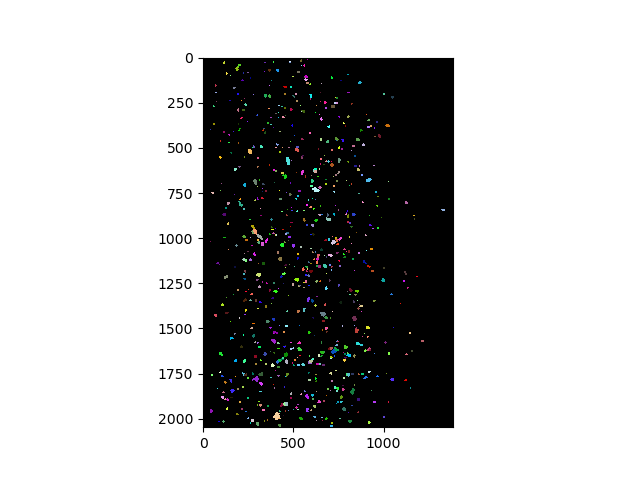

In [31]:
segmented

In [34]:
print(cle.statistics_of_labelled_pixels.__doc__)

Determines bounding box, area (in pixels/voxels), min, max, mean, standard deviation of the intensity and some
    shape descriptors of labelled objects in a label map and corresponding pixels in the original image.
    
    Instead of a label map, you can also use a binary image as a binary image is a label map with just one label.

        Note: the parameter order is different compared to regionprops.


    Parameters
    ----------
    input : Image
    labelmap : Image

    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_statisticsOfLabelledPixels
    


In [37]:
import pygalmesh

In [39]:
py

['Ball',
 'Cone',
 'Cuboid',
 'Cylinder',
 'Difference',
 'DomainBase',
 'Ellipsoid',
 'Extrude',
 'HalfSpace',
 'Intersection',
 'Polygon2D',
 'RingExtrude',
 'Rotate',
 'Scale',
 'Stretch',
 'Tetrahedron',
 'Torus',
 'Translate',
 'Union',
 '__about__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__cgal_version__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cli',
 'generate_2d',
 'generate_from_array',
 'generate_from_inr',
 'generate_mesh',
 'generate_periodic_mesh',
 'generate_surface_mesh',
 'generate_volume_mesh_from_surface_mesh',
 'main',
 'remesh_surface',
 'save_inr']